In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.image import resize

from matplotlib import pyplot as plt
import os
import random

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [2]:
df_train = pd.read_pickle('Pickles/df_train.pkl')
df_test = pd.read_pickle('Pickles/df_test.pkl')
df_val = pd.read_pickle('Pickles/df_val.pkl')

print("Train DataFrame shape:", df_train.shape)
print(df_train.head())

print("Test DataFrame shape:", df_test.shape)
print(df_test.head())

print("Validation DataFrame shape:", df_val.shape)
print(df_val.head())


Train DataFrame shape: (3087, 2)
                                               image label
0  [[[252, 217, 197], [252, 217, 197], [252, 217,...   CaS
1  [[[253, 216, 197], [252, 215, 196], [252, 215,...   CaS
2  [[[255, 255, 239], [254, 255, 238], [254, 255,...   CaS
3  [[[255, 255, 235], [255, 255, 235], [255, 255,...   CaS
4  [[[230, 194, 168], [230, 194, 168], [230, 194,...   CaS
Test DataFrame shape: (1028, 2)
                                               image label
0  [[[232, 197, 169], [232, 197, 169], [232, 197,...   CaS
1  [[[11, 13, 12], [11, 13, 12], [11, 13, 12], [1...   CaS
2  [[[193, 143, 120], [197, 147, 124], [201, 151,...   CaS
3  [[[243, 187, 162], [242, 186, 161], [240, 184,...   CaS
4  [[[100, 47, 31], [101, 48, 32], [101, 48, 32],...   CaS
Validation DataFrame shape: (1028, 2)
                                               image label
0  [[[255, 241, 225], [255, 241, 225], [255, 242,...   CaS
1  [[[205, 159, 136], [205, 159, 136], [204, 158,...   CaS
2  [[[24, 18

In [3]:
X_train = np.stack(df_train['image'].values)
X_val = np.stack(df_val['image'].values)
X_test = np.stack(df_test['image'].values)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

le = LabelEncoder()
y_train = le.fit_transform(df_train['label'])
y_val = le.transform(df_val['label'])
y_test = le.transform(df_test['label'])

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print("Labels encoded. Number of classes:", y_train.shape[1])
print("Classes:", le.classes_)

X_train shape: (3087, 256, 256, 3)
X_val shape: (1028, 256, 256, 3)
X_test shape: (1028, 256, 256, 3)
Labels encoded. Number of classes: 7
Classes: ['CaS' 'CoS' 'Gum' 'MC' 'OC' 'OLP' 'OT']


In [4]:
target_size = (224, 224)

X_train = resize(X_train, target_size).numpy()
X_val = resize(X_val, target_size).numpy()
X_test = resize(X_test, target_size).numpy()

print("Images resized.")
print("X_train_resized shape:", X_train.shape)
print("X_val_resized shape:", X_val.shape)
print("X_test_resized shape:", X_test.shape)

Images resized.
X_train_resized shape: (3087, 224, 224, 3)
X_val_resized shape: (1028, 224, 224, 3)
X_test_resized shape: (1028, 224, 224, 3)


In [5]:
X_train_vgg = vgg_preprocess(X_train.copy())
X_val_vgg = vgg_preprocess(X_val.copy())
X_test_vgg = vgg_preprocess(X_test.copy())

X_train_resnet = resnet_preprocess(X_train.copy())
X_val_resnet = resnet_preprocess(X_val.copy())
X_test_resnet = resnet_preprocess(X_test.copy())

X_train_efficientnet = efficientnet_preprocess(X_train.copy())
X_val_efficientnet = efficientnet_preprocess(X_val.copy())
X_test_efficientnet = efficientnet_preprocess(X_test.copy())

print("Preprocessing completed for VGG16, ResNet50, and EfficientNetB0.")


Preprocessing completed for VGG16, ResNet50, and EfficientNetB0.


In [5]:
def build_vgg16(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

def build_resnet50(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

def build_efficientnetB0(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

print("Build functions for pretrained models defined.")

Build functions for pretrained models defined.


In [6]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8,1.2]
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
architectures = [
    ("VGG16", build_vgg16, X_train_vgg, X_val_vgg),
    ("ResNet50", build_resnet50, X_train_resnet, X_val_resnet),
    ("EfficientNetB0", build_efficientnetB0, X_train_efficientnet, X_val_efficientnet)
]

Datagen, EarlyStopping, and architectures list setup completed.


In [8]:
input_shape = (224, 224, 3)
num_classes = y_train.shape[1]
learning_rate = 1e-4

results = []

for arch_name, build_fn, X_train_prep, X_val_prep in architectures:
    print(f"\n🚀 Training {arch_name}...")
    
    model = build_fn(input_shape, num_classes)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        datagen.flow(X_train_prep, y_train, batch_size=32),
        validation_data=(X_val_prep, y_val),
        epochs=20,
        callbacks=[early_stop],
        verbose=2
    )
    
    final_val_acc = history.history['val_accuracy'][-1]
    results.append((arch_name, final_val_acc))
    print(f"Finished {arch_name}. Final val_accuracy: {final_val_acc:.4f}")


🚀 Training VGG16...


c:\Users\manal\anaconda3\envs\CCV\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
97/97 - 383s - 4s/step - accuracy: 0.1905 - loss: 5.2743 - val_accuracy: 0.3521 - val_loss: 2.0742
Epoch 2/20
97/97 - 371s - 4s/step - accuracy: 0.2938 - loss: 2.9080 - val_accuracy: 0.4737 - val_loss: 1.4530
Epoch 3/20
97/97 - 373s - 4s/step - accuracy: 0.3826 - loss: 2.0842 - val_accuracy: 0.5623 - val_loss: 1.2213
Epoch 4/20
97/97 - 372s - 4s/step - accuracy: 0.4318 - loss: 1.7148 - val_accuracy: 0.5905 - val_loss: 1.1070
Epoch 5/20
97/97 - 371s - 4s/step - accuracy: 0.4590 - loss: 1.5198 - val_accuracy: 0.6284 - val_loss: 1.0379
Epoch 6/20
97/97 - 371s - 4s/step - accuracy: 0.5138 - loss: 1.3913 - val_accuracy: 0.6537 - val_loss: 0.9547
Epoch 7/20
97/97 - 370s - 4s/step - accuracy: 0.5296 - loss: 1.2762 - val_accuracy: 0.6800 - val_loss: 0.9061
Epoch 8/20
97/97 - 369s - 4s/step - accuracy: 0.5688 - loss: 1.2005 - val_accuracy: 0.7043 - val_loss: 0.8413
Epoch 9/20
97/97 - 368s - 4s/step - accuracy: 0.5718 - loss: 1.1644 - val_accuracy: 0.7121 - val_loss: 0.7909
Epoch 10/2

In [9]:
print("\n**All pretrained model results:**")
for arch, acc in results:
    print(f"{arch}: Validation Accuracy = {acc:.4f}")


**All pretrained model results:**
VGG16: Validation Accuracy = 0.8755
ResNet50: Validation Accuracy = 0.9650
EfficientNetB0: Validation Accuracy = 0.9329


In [7]:
X_train_resnet = resnet_preprocess(X_train.copy())
X_val_resnet = resnet_preprocess(X_val.copy())
X_test_resnet = resnet_preprocess(X_test.copy())

In [8]:
input_shape = (224, 224, 3)
num_classes = y_train.shape[1]
learning_rate = 1e-4

model = build_resnet50(input_shape, num_classes)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train_resnet, y_train, batch_size=32),
    validation_data=(X_val_resnet, y_val),
    epochs=20,
    callbacks=[early_stop],
    verbose=2
)

c:\Users\manal\anaconda3\envs\CCV\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
97/97 - 182s - 2s/step - accuracy: 0.3304 - loss: 1.8327 - val_accuracy: 0.6060 - val_loss: 1.1815
Epoch 2/20
97/97 - 168s - 2s/step - accuracy: 0.5261 - loss: 1.2691 - val_accuracy: 0.7033 - val_loss: 0.9410
Epoch 3/20
97/97 - 168s - 2s/step - accuracy: 0.6314 - loss: 1.0473 - val_accuracy: 0.7471 - val_loss: 0.8061
Epoch 4/20
97/97 - 166s - 2s/step - accuracy: 0.6718 - loss: 0.9240 - val_accuracy: 0.7831 - val_loss: 0.6842
Epoch 5/20
97/97 - 164s - 2s/step - accuracy: 0.7078 - loss: 0.8193 - val_accuracy: 0.8200 - val_loss: 0.6129
Epoch 6/20
97/97 - 165s - 2s/step - accuracy: 0.7502 - loss: 0.7210 - val_accuracy: 0.8288 - val_loss: 0.5470
Epoch 7/20
97/97 - 166s - 2s/step - accuracy: 0.7758 - loss: 0.6554 - val_accuracy: 0.8628 - val_loss: 0.4772
Epoch 8/20
97/97 - 165s - 2s/step - accuracy: 0.7959 - loss: 0.6040 - val_accuracy: 0.8842 - val_loss: 0.4283
Epoch 9/20
97/97 - 164s - 2s/step - accuracy: 0.8115 - loss: 0.5603 - val_accuracy: 0.8979 - val_loss: 0.3895
Epoch 10/2

In [9]:
model.evaluate(X_test_resnet, y_test)
print("Final evaluation on test set:")
test_loss, test_accuracy = model.evaluate(X_test_resnet, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9767 - loss: 0.1319
Final evaluation on test set:
33/33 - 40s - 1s/step - accuracy: 0.9708 - loss: 0.1582
Test Loss: 0.1582, Test Accuracy: 0.9708


Text(0.5, 1.0, 'Training and Validation Accuracy')

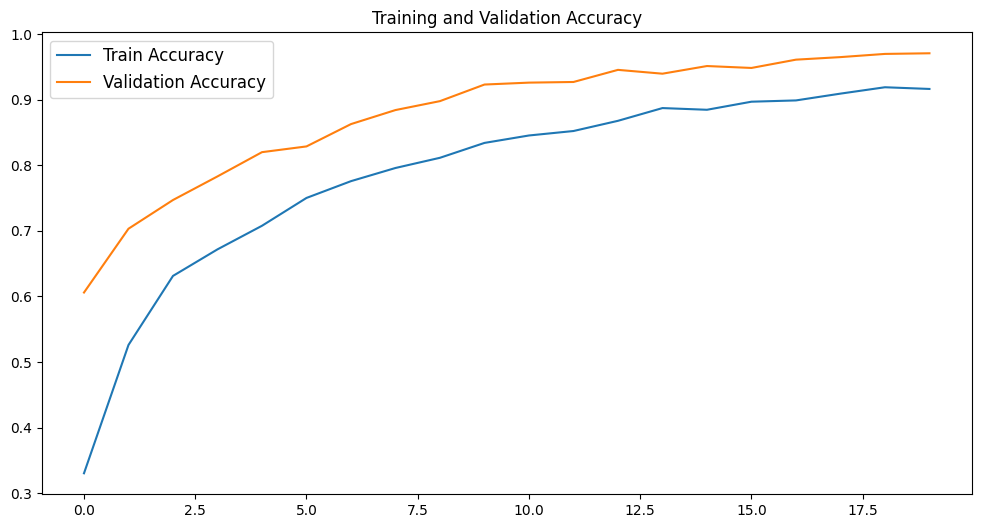

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(fontsize=12)
plt.title('Training and Validation Accuracy')


In [11]:
model.save('Models/resnet50_finetuned.h5')